In [1]:
# load std libs
from os import scandir, path
from datetime import datetime

# load third-party libraries
from tqdm import tqdm
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

# load source code
from src.image_loader import load_images
from src.utils import one_hot, shuffle, shuffle_n, get_batch
from src.alexnet import AlexNet

# initialization code
np.random.seed(42)
IMG_SIZE = 224

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### EDA
Inspect the data a bit. Make sure you've downloaded the training data, unzipped it, and placed it in the `./data/train/raw` directory.

In [16]:
image_dimensions = !find ./data/train/raw -type f -name '*.png' -exec identify -format '%w %h\n' {} +

In [17]:
image_dims_df = pd.DataFrame((map(int, dims.split(' ')) for dims in image_dimensions), columns=("w", "h"))
image_dims_df["ratio"] = image_dims_df.apply(lambda row: row.w / row.h, axis=1)
display(image_dims_df.head())

,w,h,ratio
0,163,163,1.0
1,886,886,1.0
2,498,498,1.0
3,856,856,1.0
4,300,300,1.0


# of images: 4750 

                 w            h        ratio
count  4750.000000  4750.000000  4750.000000
mean    371.465895   370.730105     1.000364
std     323.275012   318.649607     0.009373
min      49.000000    49.000000     0.943368
25%     140.000000   140.000000     1.000000
50%     266.500000   266.500000     1.000000
75%     507.750000   507.000000     1.000000
max    3991.000000  3457.000000     1.332083


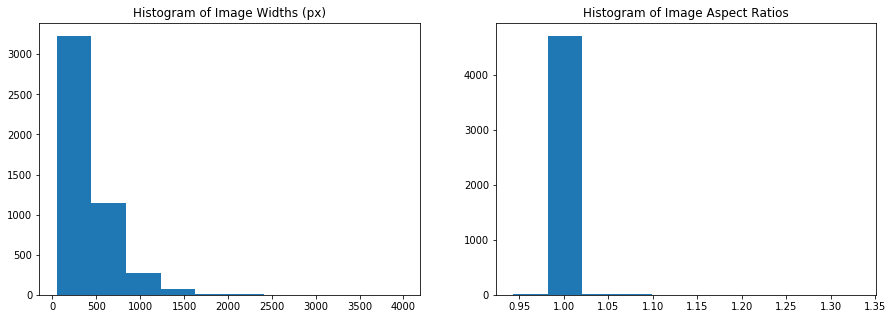

In [18]:
print("# of images: %d" % len(image_dims_df), "\n")

print(image_dims_df.describe())

fig = plt.figure(figsize=(15, 5))
sub1 = fig.add_subplot(1, 2, 1)
sub1.hist(image_dims_df.w)
sub1.set_title("Histogram of Image Widths (px)")
sub2 = fig.add_subplot(1, 2, 2)
sub2.hist(image_dims_df.ratio)
sub2.set_title("Histogram of Image Aspect Ratios")
None

### Resize images
Run this once to resize the images and save to disk. This takes a few minutes.

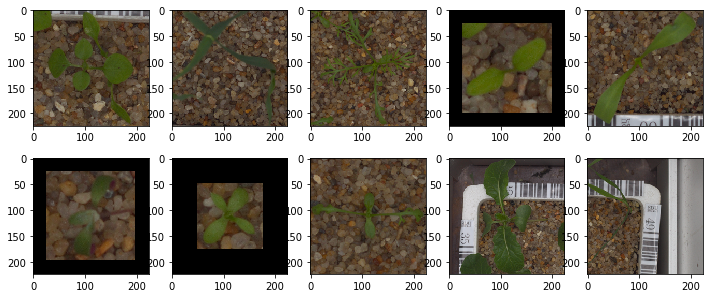

In [2]:
train_imgs = load_images("./data/train/raw/*/*.png",
                         desired_size=IMG_SIZE,
                         scale_down=True,
                         pad_up=True,
                         write_to="./data/train/resized",
                         preserve_dir_tree_at="./data/train/raw")

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i + 1)
    rand_i = np.random.randint(0, len(train_imgs))
    sub.imshow(train_imgs[rand_i])

del train_imgs

In [2]:
class_names = [f.name for f in scandir("./data/train/raw") if f.is_dir()]
print(class_names)

train_imgs_ord = []
train_labels_ord = []
file_paths_ord = []

for i, name in enumerate(class_names):
    imgs, file_paths = load_images("./data/train/resized/%s/*.png" % name, return_file_paths=True)
    train_imgs_ord.extend(imgs)
    train_labels_ord.extend([i] * len(imgs))
    file_paths_ord.extend(file_paths)

train_imgs_ord = np.array(train_imgs_ord, dtype=np.float32)
print(train_imgs_ord.shape)
train_labels_ord = one_hot(train_labels_ord)
print(train_labels_ord.shape)

['Charlock', 'Common Chickweed', 'Loose Silky-bent', 'Black-grass', 'Cleavers', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Fat Hen', 'Common wheat', 'Shepherds Purse', 'Sugar beet', 'Maize']
(4750, 224, 224, 3)
(4750, 12)


In [3]:
dev_fraction = 0.15
num_dev_examples = math.floor(len(train_imgs_ord) * dev_fraction)
train_imgs_shuf, train_labels_shuf, file_paths_shuf = shuffle_n(train_imgs_ord, train_labels_ord, file_paths_ord)
train_data, train_labels, train_file_paths = (train_imgs_shuf[:-num_dev_examples],
                                              train_labels_shuf[:-num_dev_examples],
                                              file_paths_shuf[:-num_dev_examples])
dev_data, dev_labels, _ = (train_imgs_shuf[-num_dev_examples:],
                           train_labels_shuf[-num_dev_examples:],
                           file_paths_shuf[-num_dev_examples:])

del train_imgs_ord, train_labels_ord, file_paths_ord, train_imgs_shuf, train_labels_shuf, file_paths_shuf
print(train_data.shape)
print(train_labels.shape)
print(dev_data.shape)
print(dev_labels.shape)

(4038, 224, 224, 3)
(4038, 12)
(712, 224, 224, 3)
(712, 12)


In [4]:
batch_size = 128
num_classes = train_labels.shape[1]

tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(batch_size, IMG_SIZE, IMG_SIZE, 3), name="X")
Y = tf.placeholder(tf.float32, shape=(batch_size, num_classes), name="Y")
dropout = tf.placeholder(tf.float16, name="dropout_rate")
learn_rate = tf.placeholder(tf.float16, name="learning_rate")

model = AlexNet(X, dropout, num_classes)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.logits, labels=Y))

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learn_rate)
    optimization_op = optimizer.minimize(loss)

tf.summary.scalar('loss', loss)

with tf.name_scope("accuracy"):
    predictions = tf.argmax(model.logits, axis=1)
    correct_predictions = tf.equal(predictions, tf.argmax(Y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

tf.summary.scalar('training_accuracy', accuracy)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./tensorboard")
saver = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [9]:
def train_and_evaluate(train_data, train_labels, dev_data, dev_labels, learning_rate, num_epochs, dropout_rate=0.5, display_step=10):
    training_batches_per_epoch = int(np.floor(train_data.shape[0] / batch_size))
    dev_batches_per_epoch = int(np.floor(dev_data.shape[0] / batch_size))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer.add_graph(sess.graph)

        for epoch in range(num_epochs):
            print("{} epoch number: {}".format(datetime.now(), epoch + 1))
            shuffle(train_data, train_labels)
            
            for step in tqdm(range(training_batches_per_epoch)):
                x_batch, y_batch = get_batch(train_data, train_labels, step, batch_size)
                sess.run(optimization_op, feed_dict={X: x_batch, Y: y_batch, dropout: dropout_rate, learn_rate: learning_rate })

                # every so often, report the progress of our loss and training accuracy
                if step % display_step == 0:
                    summ = sess.run(merged_summary, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
                    writer.add_summary(summ, epoch * training_batches_per_epoch + step)
                    writer.flush()

            dev_acc = 0
            dev_count = 0
            for step in range(dev_batches_per_epoch):
                x_batch, y_batch = get_batch(dev_data, dev_labels, step, batch_size)
                acc = sess.run(accuracy, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
                dev_acc += acc
                dev_count += 1

            print("dev accuracy = {:.4f}".format(dev_acc / dev_count))

        # save the model to disk so we can load it up later for use by `./eval.py`
        saver.save(sess, "./tensorflow-ckpt/model.ckpt")

In [11]:
train_and_evaluate(train_data, train_labels, dev_data, dev_labels,
                   learning_rate=8e-5,
                   num_epochs=20,
                   dropout_rate=0.5,
                   display_step=5)

2018-03-09 20:19:23.785001 epoch number: 1


100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


dev accuracy = 0.1906
2018-03-09 20:19:31.728148 epoch number: 2


100%|██████████| 31/31 [00:06<00:00,  4.55it/s]


dev accuracy = 0.2812
2018-03-09 20:19:39.603100 epoch number: 3


100%|██████████| 31/31 [00:06<00:00,  4.55it/s]


dev accuracy = 0.3906
2018-03-09 20:19:47.485655 epoch number: 4


100%|██████████| 31/31 [00:06<00:00,  4.55it/s]


dev accuracy = 0.4688
2018-03-09 20:19:55.380333 epoch number: 5


100%|██████████| 31/31 [00:06<00:00,  4.55it/s]


dev accuracy = 0.5406
2018-03-09 20:20:03.265699 epoch number: 6


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.5875
2018-03-09 20:20:11.167744 epoch number: 7


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.6516
2018-03-09 20:20:19.064189 epoch number: 8


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.6906
2018-03-09 20:20:26.954424 epoch number: 9


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.6844
2018-03-09 20:20:34.843988 epoch number: 10


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.7000
2018-03-09 20:20:42.739401 epoch number: 11


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.7234
2018-03-09 20:20:50.638825 epoch number: 12


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.7234
2018-03-09 20:20:58.525674 epoch number: 13


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.7859
2018-03-09 20:21:06.426559 epoch number: 14


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.7859
2018-03-09 20:21:14.320553 epoch number: 15


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.7922
2018-03-09 20:21:22.217127 epoch number: 16


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.8000
2018-03-09 20:21:30.110820 epoch number: 17


100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


dev accuracy = 0.7812
2018-03-09 20:21:38.016402 epoch number: 18


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.8031
2018-03-09 20:21:45.923214 epoch number: 19


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.7953
2018-03-09 20:21:53.823471 epoch number: 20


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


dev accuracy = 0.7906


In [4]:
def augment(data, labels):
    # generate the mirror images
    mirror_data = data[:, :, ::-1, :]
    data_aug = np.concatenate((data, mirror_data))

    # generate rotations
    rot90 = np.rot90(data_aug, axes=(1, 2))
    rot180 = np.rot90(rot90, axes=(1, 2))
    rot270 = np.rot90(rot180, axes=(1, 2))
    data_aug = np.concatenate((data_aug, rot90, rot180, rot270))
    
    labels_aug = np.tile(labels, (8, 1))

    return data_aug, labels_aug

train_data_aug, train_labels_aug = augment(train_data, train_labels)
print(train_data_aug.shape)
print(train_labels_aug.shape)

(32304, 224, 224, 3)
(32304, 12)


In [13]:
train_and_evaluate(train_data_aug, train_labels_aug, dev_data, dev_labels,
                   learning_rate=1e-5,
                   num_epochs=20,
                   dropout_rate=0.5,
                   display_step=5)

2018-03-09 20:22:21.793205 epoch number: 1


100%|██████████| 252/252 [00:54<00:00,  4.59it/s]


dev accuracy = 0.3766
2018-03-09 20:23:21.652223 epoch number: 2


100%|██████████| 252/252 [00:54<00:00,  4.59it/s]


dev accuracy = 0.4984
2018-03-09 20:24:21.558453 epoch number: 3


100%|██████████| 252/252 [00:54<00:00,  4.59it/s]


dev accuracy = 0.5500
2018-03-09 20:25:21.422480 epoch number: 4


100%|██████████| 252/252 [00:54<00:00,  4.59it/s]


dev accuracy = 0.6484
2018-03-09 20:26:21.252790 epoch number: 5


100%|██████████| 252/252 [00:54<00:00,  4.59it/s]


dev accuracy = 0.6594
2018-03-09 20:27:21.094032 epoch number: 6


100%|██████████| 252/252 [00:54<00:00,  4.58it/s]


dev accuracy = 0.7156
2018-03-09 20:28:21.042081 epoch number: 7


100%|██████████| 252/252 [00:55<00:00,  4.58it/s]


dev accuracy = 0.7625
2018-03-09 20:29:21.001252 epoch number: 8


100%|██████████| 252/252 [00:55<00:00,  4.58it/s]


dev accuracy = 0.7578
2018-03-09 20:30:20.998123 epoch number: 9


100%|██████████| 252/252 [00:55<00:00,  4.58it/s]


dev accuracy = 0.8016
2018-03-09 20:31:20.977900 epoch number: 10


100%|██████████| 252/252 [00:55<00:00,  4.58it/s]


dev accuracy = 0.7797
2018-03-09 20:32:20.987001 epoch number: 11


100%|██████████| 252/252 [00:55<00:00,  4.58it/s]


dev accuracy = 0.8125
2018-03-09 20:33:21.028385 epoch number: 12


100%|██████████| 252/252 [00:55<00:00,  4.58it/s]


dev accuracy = 0.8063
2018-03-09 20:34:20.999133 epoch number: 13


100%|██████████| 252/252 [00:55<00:00,  4.58it/s]


dev accuracy = 0.8156
2018-03-09 20:35:20.997325 epoch number: 14


100%|██████████| 252/252 [00:55<00:00,  4.58it/s]


dev accuracy = 0.8266
2018-03-09 20:36:20.980190 epoch number: 15


100%|██████████| 252/252 [00:55<00:00,  4.57it/s]


dev accuracy = 0.8297
2018-03-09 20:37:20.995462 epoch number: 16


100%|██████████| 252/252 [00:55<00:00,  4.57it/s]


dev accuracy = 0.8141
2018-03-09 20:38:21.061483 epoch number: 17


100%|██████████| 252/252 [00:55<00:00,  4.57it/s]


dev accuracy = 0.8453
2018-03-09 20:39:21.125646 epoch number: 18


100%|██████████| 252/252 [00:55<00:00,  4.57it/s]


dev accuracy = 0.8313
2018-03-09 20:40:21.234701 epoch number: 19


100%|██████████| 252/252 [00:55<00:00,  4.57it/s]


dev accuracy = 0.8391
2018-03-09 20:41:21.306988 epoch number: 20


100%|██████████| 252/252 [00:55<00:00,  4.57it/s]


dev accuracy = 0.8297


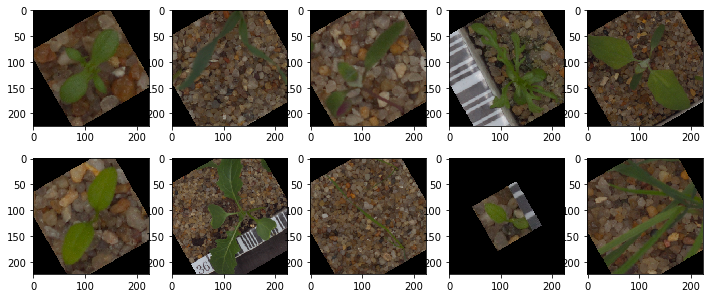

In [6]:
rotated_imgs = load_images(train_file_paths,
                           desired_size=IMG_SIZE,
                           scale_down=True,
                           pad_up=True,
                           rotate=30,
                           write_to="./data/train/rotated",
                           preserve_dir_tree_at="./data/train/resized")

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i + 1)
    rand_i = np.random.randint(0, len(rotated_imgs))
    sub.imshow(rotated_imgs[rand_i])

del rotated_imgs

In [5]:
train_imgs_rot = []
train_labels_rot = []

for i, name in enumerate(class_names):
    imgs = load_images("./data/train/rotated/%s/*.png" % name)
    train_imgs_rot.extend(imgs)
    train_labels_rot.extend([i] * len(imgs))

train_imgs_rot = np.array(train_imgs_rot, dtype=np.float32)

train_imgs_rot, train_labels_rot = augment(train_imgs_rot, 
                                           one_hot(train_labels_rot))

train_data_aug_2 = np.concatenate((train_data_aug, train_imgs_rot))
train_labels_aug_2 = np.concatenate((train_labels_aug, train_labels_rot))

del train_data_aug, train_labels_aug, train_data, train_labels, train_file_paths

print(train_data_aug_2.shape)
print(train_labels_aug_2.shape)

(64608, 224, 224, 3)
(64608, 12)


In [15]:
train_and_evaluate(train_data_aug_2, train_labels_aug_2, dev_data, dev_labels,
                   learning_rate=1e-5,
                   num_epochs=20,
                   dropout_rate=0.5,
                   display_step=5)

2018-03-09 20:44:15.479133 epoch number: 1


100%|██████████| 504/504 [01:49<00:00,  4.59it/s]


dev accuracy = 0.4625
2018-03-09 20:46:16.254042 epoch number: 2


100%|██████████| 504/504 [01:50<00:00,  4.57it/s]


dev accuracy = 0.6188
2018-03-09 20:48:15.846787 epoch number: 3


100%|██████████| 504/504 [01:50<00:00,  4.57it/s]


dev accuracy = 0.7297
2018-03-09 20:50:15.663503 epoch number: 4


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.7641
2018-03-09 20:52:15.500214 epoch number: 5


100%|██████████| 504/504 [01:50<00:00,  4.57it/s]


dev accuracy = 0.7969
2018-03-09 20:54:15.149979 epoch number: 6


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8250
2018-03-09 20:56:14.947864 epoch number: 7


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.7969
2018-03-09 20:58:14.780105 epoch number: 8


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8391
2018-03-09 21:00:14.650531 epoch number: 9


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8266
2018-03-09 21:02:14.412073 epoch number: 10


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8344
2018-03-09 21:04:14.259877 epoch number: 11


100%|██████████| 504/504 [01:50<00:00,  4.57it/s]


dev accuracy = 0.8375
2018-03-09 21:06:14.074191 epoch number: 12


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8547
2018-03-09 21:08:13.973880 epoch number: 13


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8484
2018-03-09 21:10:13.798704 epoch number: 14


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8578
2018-03-09 21:12:13.724393 epoch number: 15


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8594
2018-03-09 21:14:13.572334 epoch number: 16


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8516
2018-03-09 21:18:13.205535 epoch number: 18


100%|██████████| 504/504 [01:50<00:00,  4.57it/s]


dev accuracy = 0.8719
2018-03-09 21:20:13.078088 epoch number: 19


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8672
2018-03-09 21:22:12.901503 epoch number: 20


100%|██████████| 504/504 [01:50<00:00,  4.56it/s]


dev accuracy = 0.8672


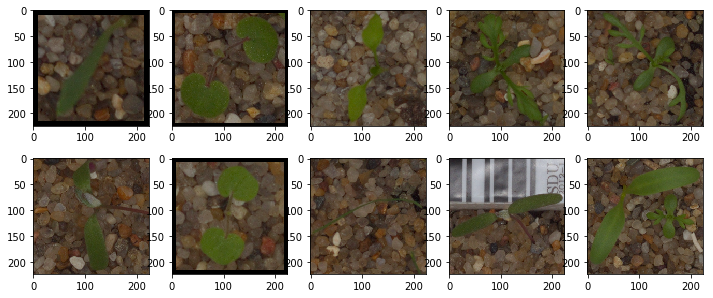

In [8]:
test_imgs = load_images("./data/test/raw/*.png",
                         desired_size=IMG_SIZE,
                         scale_down=True,
                         pad_up=True,
                         write_to="./data/test/resized")

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i + 1)
    rand_i = np.random.randint(0, len(test_imgs))
    sub.imshow(test_imgs[rand_i])

del test_imgs

In [6]:
test_imgs, file_names = load_images("./data/test/resized/*.png", return_file_paths=True)
test_imgs = np.array(test_imgs)
file_names = [path.basename(file_path) for file_path in file_names]

In [17]:
# create a new graph which differs slightly from the previous
inference_graph = tf.Graph()
with inference_graph.as_default():
    X = tf.placeholder(tf.float32, shape=(len(test_imgs), IMG_SIZE, IMG_SIZE, 3), name="X")
    dropout = tf.constant(0)

    model = AlexNet(X, dropout, num_classes)
    
    predictions = tf.argmax(model.logits, axis=1)
    
    saver = tf.train.Saver()
    
    # restore the model in this graph and see which predications were wrong
    with tf.Session() as sess:
        saver.restore(sess, "./tensorflow-ckpt/model.ckpt")
        test_predictions = sess.run(predictions, feed_dict={X: test_imgs})
        prediction_df = pd.DataFrame(data={"file": file_names, "species": np.array(class_names)[test_predictions]})
        display(prediction_df.head())
        prediction_df.to_csv("./test_predictions.csv", index=False)

INFO:tensorflow:Restoring parameters from ./tensorflow-ckpt/model.ckpt


,file,species
0,e19673dc9.png,Charlock
1,a8c8a1db0.png,Shepherds Purse
2,76dbd1054.png,Scentless Mayweed
3,148bbda66.png,Charlock
4,9c777333d.png,Shepherds Purse


In [7]:
model = tf.keras.applications.VGG16(weights=None, classes=12)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(train_data_aug_2, train_labels_aug_2,
          batch_size=64,
          epochs=10,
          shuffle=True,
          validation_data=(dev_data, dev_labels))

model.save('resnet50_model.h5')

Train on 64608 samples, validate on 712 samples
Epoch 1/10
64608/64608 [==============================]64608/64608 [==============================] - 681s 11ms/step - loss: 1.1770 - acc: 0.5794 - val_loss: 0.4993 - val_acc: 0.8258

Epoch 2/10
64608/64608 [==============================]64608/64608 [==============================] - 673s 10ms/step - loss: 0.3002 - acc: 0.8877 - val_loss: 0.3011 - val_acc: 0.8947

Epoch 3/10
64608/64608 [==============================]64608/64608 [==============================] - 671s 10ms/step - loss: 0.2043 - acc: 0.9219 - val_loss: 0.3158 - val_acc: 0.9003

Epoch 4/10
64608/64608 [==============================]64608/64608 [==============================] - 671s 10ms/step - loss: 0.1465 - acc: 0.9419 - val_loss: 0.3155 - val_acc: 0.9101

Epoch 5/10
64608/64608 [==============================]64608/64608 [==============================] - 670s 10ms/step - loss: 0.1117 - acc: 0.9568 - val_loss: 0.3645 - val_acc: 0.9031

Epoch 6/10
64608/64608 [========

In [8]:
test_predictions = np.argmax(model.predict(test_imgs), axis=1)
prediction_df = pd.DataFrame(data={"file": file_names, "species": np.array(class_names)[test_predictions]})
display(prediction_df.head())
prediction_df.to_csv("./test_predictions.csv", index=False)

,file,species
0,e19673dc9.png,Charlock
1,a8c8a1db0.png,Shepherds Purse
2,76dbd1054.png,Scentless Mayweed
3,148bbda66.png,Charlock
4,9c777333d.png,Shepherds Purse
